_Version log: Finding the best samples though brute force and manual tweaking. Also started to compare different optimisation results._

In [175]:
import CS_functions as cs
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt, colors as mplcolors
from scipy import fft as spfft
from scipy.constants import speed_of_light as C
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})
#np.set_printoptions(threshold=sys.maxsize)

In [176]:
file_number = 15 # Use a noiseless version of the interferogram for good convergence
file_name = "1dmockanderrors{:d}".format(file_number)
#file_name = "240802134128_processed1d"

file_type = ".csv"
target, uncertainties = cs.open_dataset(file_name, file_type)
optlocs_file = "data\\" + file_name +"_optlocs.csv"

reduced_points = 8
total_points = len(target)

In [177]:
full_data = cs.open_csv(optlocs_file, reduced_points)

In [178]:
#test = [79,  86, 93, 100, 107, 114, 121, 40] # Manual
test = cs.subsample_1d(total_points, reduced_points, subsampling_method= "regular") # referance

test = np.array(test)
len(test)

8

In [179]:
full_data = np.vstack([full_data, test])
full_data.shape

(122, 8)

In [180]:
regularization_coeffient = 1e-4

def find_error(locations):
    assert locations.ndim == 1
    locations = locations[~np.isnan(locations)].astype(int)

    samples = np.full_like(target, np.nan)
    samples[locations] = target[locations]
    result = cs.compressed_sensing(samples, regularization_coeffient)
    error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

    return error

#errors = [find_error(locations) for locations in tqdm(full_data)]
errors = [cs.evaluate_score(locations, target, uncertainties, regularization_coeffient) for locations in tqdm(full_data)]
errors = np.array(errors)


100%|██████████| 122/122 [00:02<00:00, 58.16it/s]


In [181]:
sort = np.argsort(errors)
print(errors[-1])
errors = errors[sort]
full_data = full_data[sort]

3.5912244394259187


In [182]:
print(*zip(errors, full_data), sep= "\n")

(1.6528819351534367, array([ 89,  93,  96,  97, 100, 101, 103, 104]))
(1.959236548800688, array([  2,  34,  59, 100, 104, 145, 176, 197]))
(2.2941126799301292, array([100,  93,  74,  86, 110, 106,  90,  88]))
(2.2941126799301292, array([100,  93,  74,  86, 110, 106,  90,  88]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,  91,  57,  86, 114, 125, 159, 137]))
(2.588625284132367, array([  0,

In [183]:
sa_error = find_error(test)
brute_errors = np.empty((reduced_points, total_points))

fixed_points = np.repeat(test[None, :], reduced_points, axis= 0)
fixed_points = fixed_points[~np.eye(reduced_points, dtype= bool)] #one of the samples is not fixed
fixed_points = fixed_points.reshape((reduced_points, reduced_points-1)) #tell numpy to stop flattening my array

for n in np.arange(reduced_points):
    trail_samples = np.copy(test)
    for trail_sample in np.arange(total_points):
        trail_samples[n] = trail_sample
        brute_error = find_error(trail_samples) #This is the chi-squared
        brute_errors[n, trail_sample] = brute_error

-1.0537949553465187


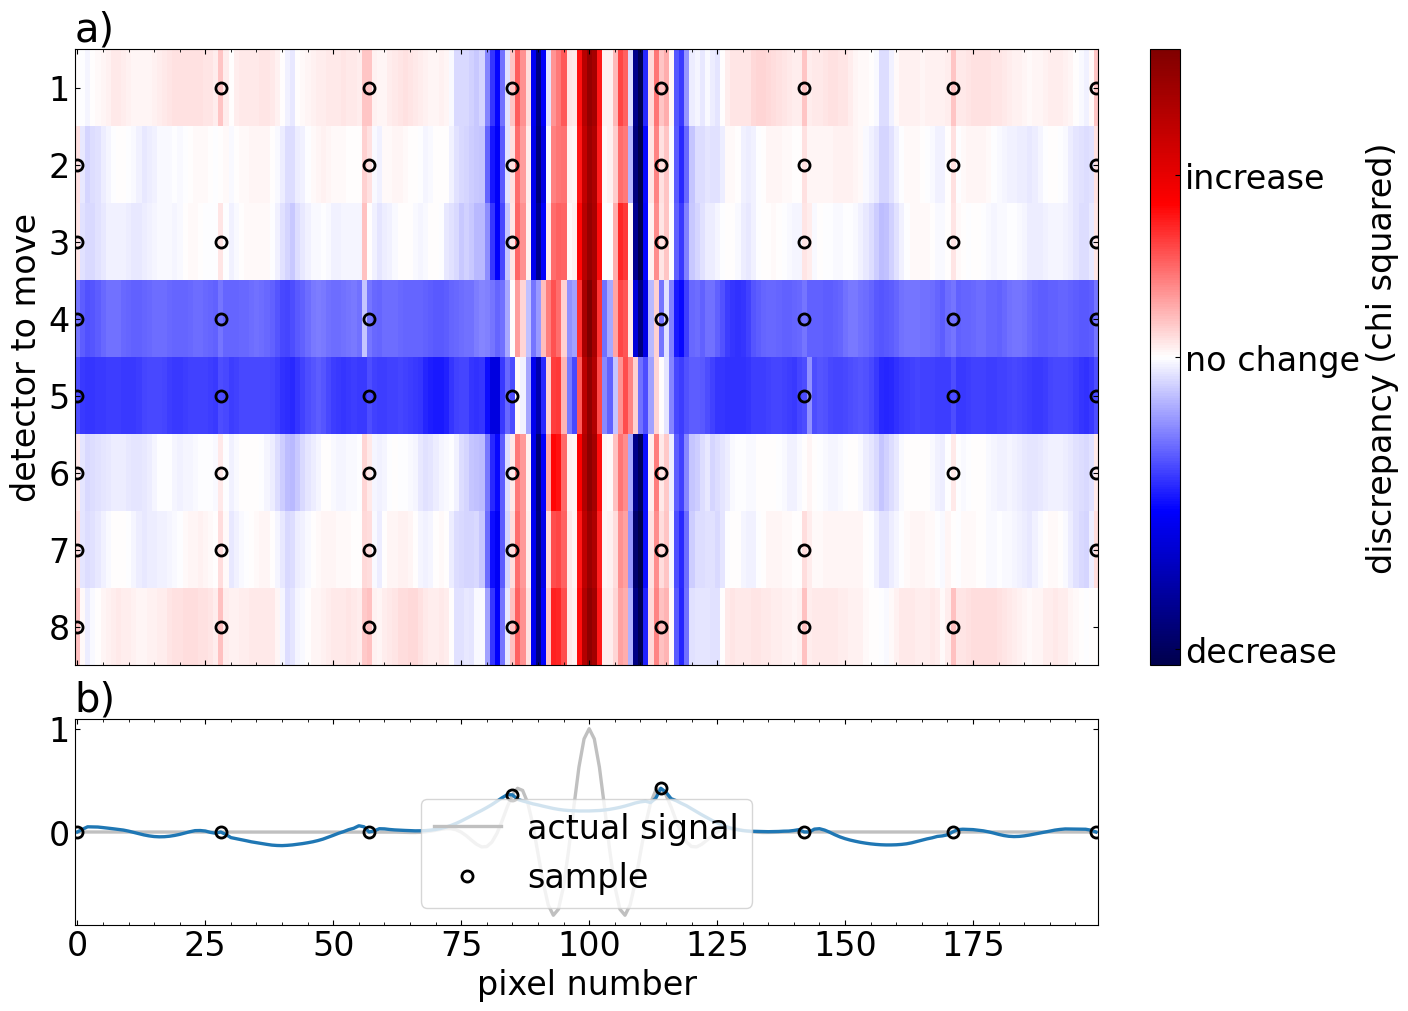

In [186]:
difference = brute_errors -sa_error

### ticks

max_diff = np.max(difference)
min_diff = np.min(difference)
print(min_diff) # If this is less than zero then SA failed to find the best solution.
if min_diff >= 0: min_diff = -1 #If this is more than or equal to zero then my code breaks!
if max_diff <= 0: max_diff = 1 #If this is less than or equal to zero then my code breaks!

pos_zticks = np.arange(0, max_diff, 10**np.floor(np.log10(np.abs(max_diff))))
neg_zticks = np.arange(0, min_diff, -10**np.floor(np.log10(np.abs(min_diff)))) # np.floor() is NOT the same as int() for negative numbers!
zticks = np.unique(np.concatenate([pos_zticks, neg_zticks]))

zticklabels = np.full_like(zticks, "", dtype= object)
zticklabels[0] = "decrease"
zticklabels[-1] = "increase"
zticklabels[zticks == 0] = "no change"

### colourmap

norm = mplcolors.TwoSlopeNorm(0, vmin=min_diff, vmax=max_diff) #Greatly exagerates the possible improvements

#c, v = ["darkgreen","green","palegreen","white","lightcoral","red","darkred"], [0, 0.1, 0.4, 0.5, 0.6, 0.85, 1.0] # colour, position on scale
#cmap= mplcolors.LinearSegmentedColormap.from_list('rg', list(zip(v,c)), N=256) # very festive! Creates a color scale by interpolating between the specified colours.
cmap= "seismic"

### plot

fig, axs = plt.subplots(2, 1, figsize= (14, 10), sharex= True, height_ratios= (3, 1), layout= "constrained")

im = axs[0].imshow(difference, aspect= "auto", interpolation= "none", cmap= cmap, norm= norm)
cbar = fig.colorbar(im, label= "discrepancy (chi squared)")
cbar.set_ticks(ticks= zticks, labels=zticklabels)

axs[0].plot(fixed_points ,np.arange(reduced_points), linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8) #kind of cursed but it works
axs[0].set(ylabel= "detector to move", yticks= np.arange(reduced_points), yticklabels= np.arange(1, reduced_points+1))
axs[0].set_title("a)", loc= "left")

samples = np.full_like(target, np.nan)
samples[test] = target[test]
test_result = cs.compressed_sensing(samples, regularization_coeffient)

axs[1].plot(target, color= "silver", label= "actual signal")
axs[1].plot(test_result, color= "tab:blue", label= "")
axs[1].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8, label= "sample")
axs[1].set(xlabel= "pixel number")
axs[1].set_title("b)", loc= "left")
axs[1].legend()

plt.show()

## COMPARING DIFFERENT RESULTS

In [192]:
file_name = "240802134128_processed1d"
target, uncertainties = cs.open_dataset(file_name, file_type)
reduced_points = 12
total_points = len(target)

optimised_detectors = {"Fabricated Schottky Array": [12,16,20,24,28,32,36,40],
                       "Uniform Sampling": cs.subsample_1d(total_points, reduced_points, "regular"),
                       "Douglas Peucker": [31,  5,  9, 14, 19, 24, 28, 36, 25, 13, 47, 16],
                       "Greedy": [32, 35, 48,  5, 42, 28, 36, 10, 17,  0, 52, 50],
                       "MCMC Metropolis": [ 4,  9, 12, 22, 28, 29, 31, 33, 35, 36, 43, 51],
                       "Simulated Annealing": [ 1,  6,  7, 10, 13, 20, 28, 31, 32, 36, 40, 47]}

runtimes = ["0ms", "1 ms", "200 ms", "2 min", "20 min", "30 min"]
scores = [cs.evaluate_score(sensors, target, uncertainties, regularization_coeffient) for sensors in optimised_detectors.values()]

pixel_pitch = 1000 #um
theta = 200 #arcminutes # APPOX. NOT MEASURED.

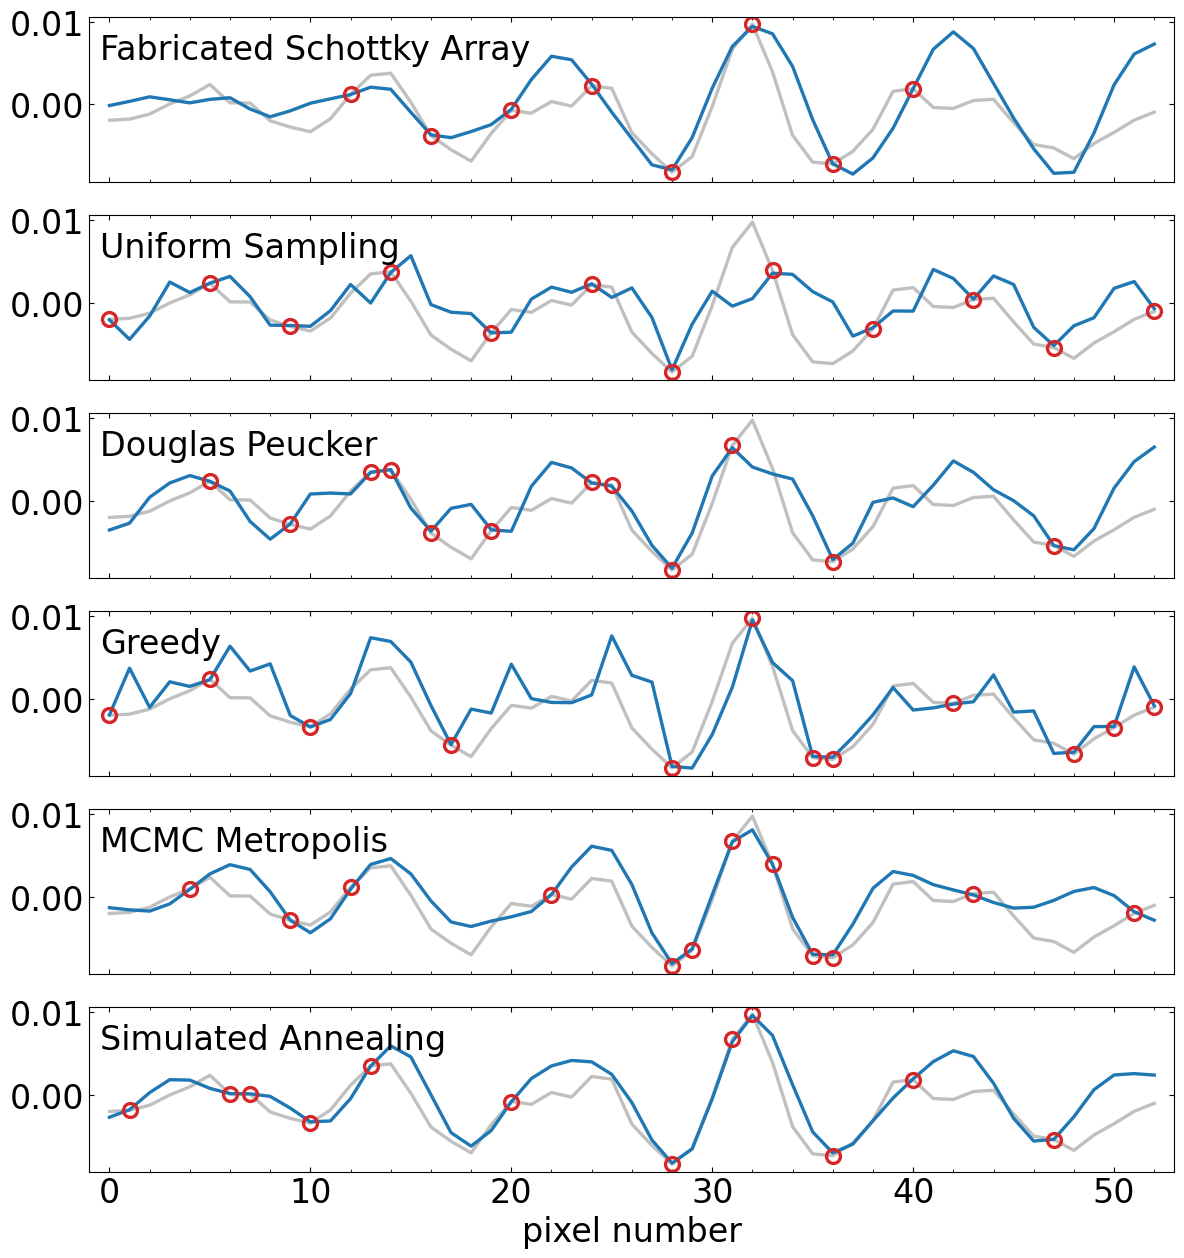

In [193]:
### INTERFEROGRAMS

number_of_methods = len(optimised_detectors)

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.2}, facecolor='none')

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), runtimes, scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(target, color= "silver")
    ax.plot(result)
    ax.plot(sensors, samples[sensors], linestyle= "None", marker= "o", markeredgecolor= "tab:red", markerfacecolor= "None")
    ax.set(xlim= (-1, total_points), facecolor='white')
    ax.annotate(method, (0.01,0.9), xycoords= 'axes fraction', ha= "left", va= "top")
    #ax.annotate("runtime= {0:s}".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "pixel number")

plt.show()

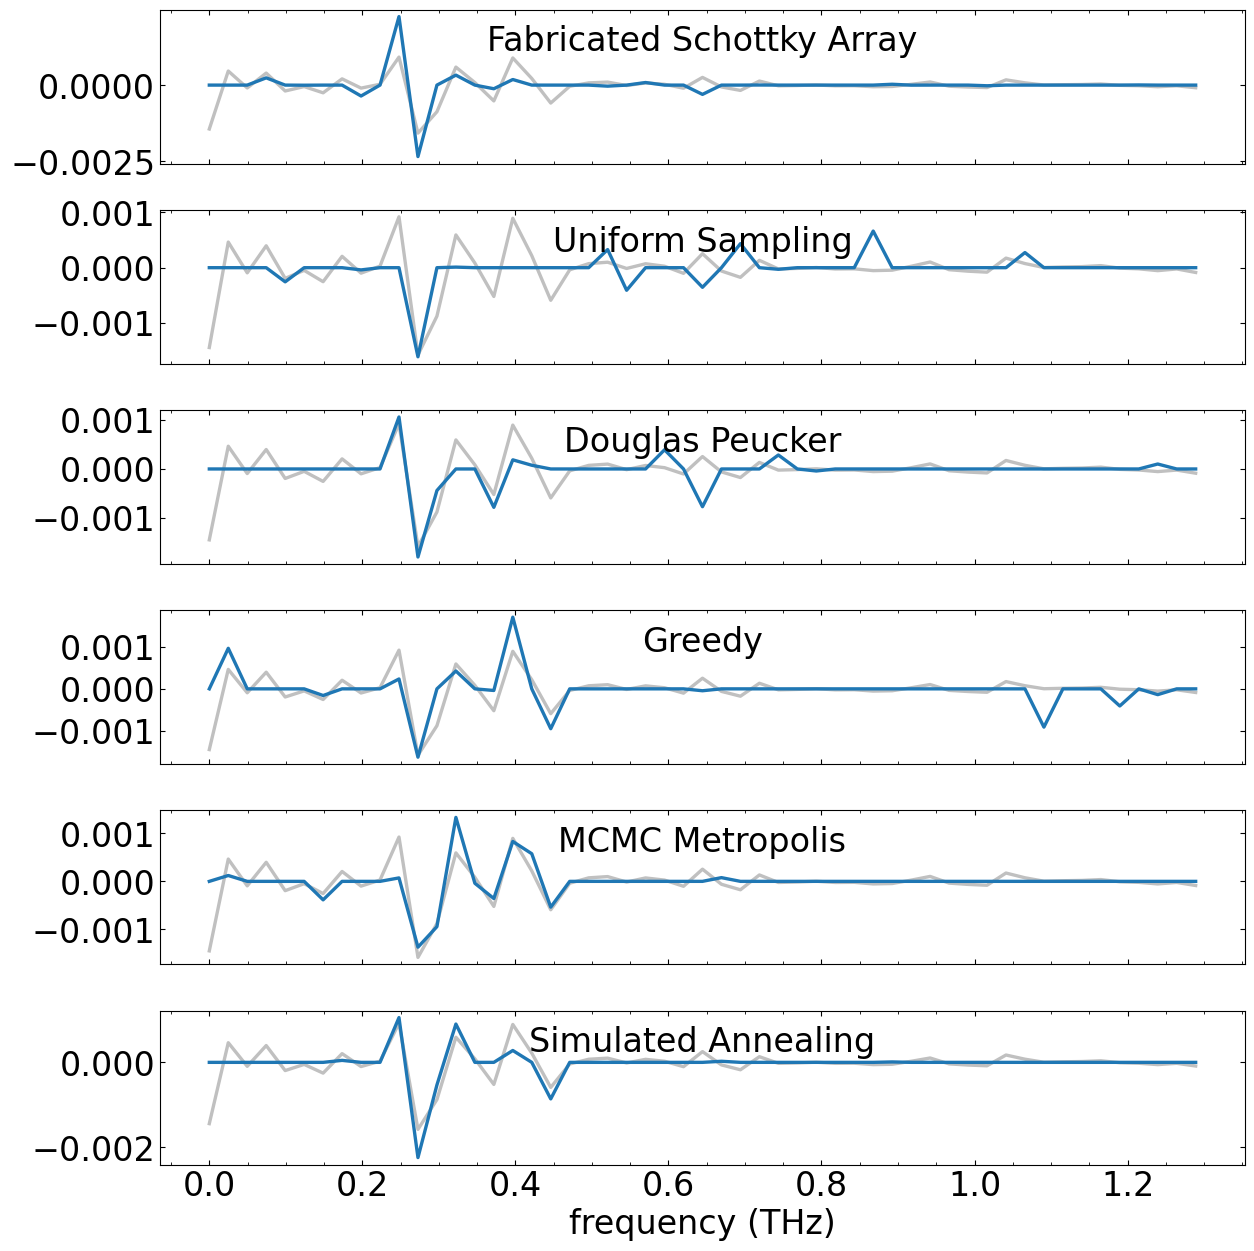

In [194]:
### DCT BASIS

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.3}, facecolor='none')

nyquist = C / (4 *pixel_pitch*1e-6 *np.sin(np.deg2rad(theta/60)))
nyquist *= 1e-12
freqs = np.linspace(0, nyquist, total_points) # THIS IS APPROXIMATE WHEN TOTAL_POINTS IS ODD.

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), runtimes, scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient, domain= "DCT")
    ax.plot(freqs, spfft.dct(target, type= 1, norm= "forward"), color= "silver")
    ax.plot(freqs, result)
    ax.set(facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    #ax.annotate("runtime= {0:s}".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "frequency (THz)")

plt.show()

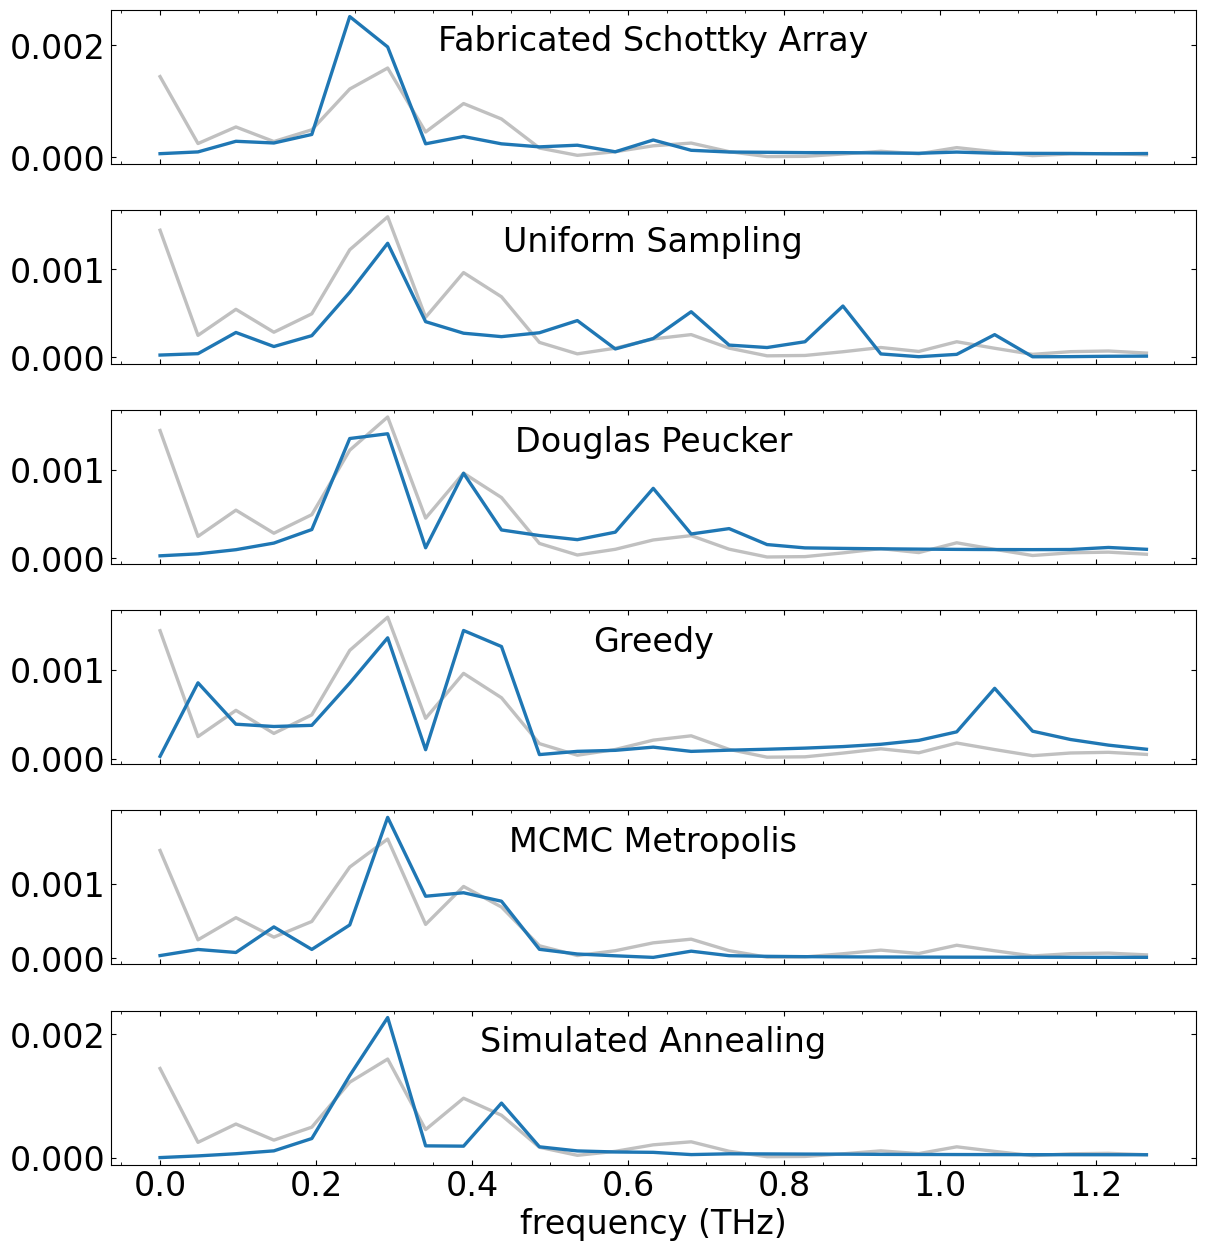

In [195]:
### POWER SPECTRUM

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.3}, facecolor='none')

freqs = np.fft.rfftfreq(total_points, pixel_pitch*1e-6)
freqs /= 2*np.sin(np.deg2rad(theta/60))
freqs *= C
freqs *= 1e-12

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), runtimes, scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(freqs, np.abs(np.fft.rfft(target, norm= "forward")), color= "silver")
    ax.plot(freqs, np.abs(np.fft.rfft(result, norm= "forward")))
    ax.set(facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    #ax.annotate("runtime= {0:s}".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")

axs[-1].set(xlabel= "frequency (THz)")

plt.show()